In [3]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import squareform
from itertools import combinations, product
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from goatools import obo_parser
from scipy.linalg import eigh
from itertools import islice

import os
import time
import gzip
import graco
import shutil
import zipfile
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import Bio.UniProt.GOA as GOA
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()
pd.set_option('display.max_columns', 50)

# Downloads

### BioGRID

In [2]:
URL_BioGRID = "https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-3.5.177/BIOGRID-ORGANISM-3.5.177.tab2.zip"
FILEPATH_BioGRID = "/Users/markusyoussef/Desktop/git/graco/data/BIOGRID-ORGANISM-3.5.177.tab2.zip"

In [3]:
r = requests.get(URL_BioGRID, allow_redirects=True)
with open(FILEPATH_BioGRID, 'wb') as f:
    f.write(r.content)

In [5]:
with zipfile.ZipFile(FILEPATH_BioGRID, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(FILEPATH_BioGRID))

# BioGRID, define systematic population

In [4]:
URL_BioGRID = "https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-3.5.177/BIOGRID-ORGANISM-3.5.177.tab2.zip"
FILEPATH_BioGRID = "/Users/markusyoussef/Desktop/git/graco/data/BIOGRID-ORGANISM-3.5.177.tab2.zip"

In [5]:
# load BioGRID file as dataframe
FILENAME_sc_BioGRID = "BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.177.tab2.txt"
FILEPATH_sc_BioGRID = os.path.dirname(FILEPATH_BioGRID) + '/' + FILENAME_sc_BioGRID

# remove entrez ids and scores because of mixed datatypes 
BioGRID_sc_df = pd.read_csv(FILEPATH_sc_BioGRID, delimiter='\t',
                           usecols=[index for index in range(24) if index not in {1,2,18}])

In [6]:
# BioGRID universe is the collection of every gene known to BioGRID
universe_BioGRID = set(BioGRID_sc_df['BioGRID ID Interactor A']) | \
                   set(BioGRID_sc_df['BioGRID ID Interactor B'])

systematic_universe_BioGRID = set(BioGRID_sc_df['Systematic Name Interactor A']) | \
                              set(BioGRID_sc_df['Systematic Name Interactor B'])
systematic_universe_BioGRID.remove('-')

print(f'BioGRID:            universe size: {len(universe_BioGRID)}')
print(f'BioGRID: systematic universe size: {len(systematic_universe_BioGRID)}')

BioGRID:            universe size: 7172
BioGRID: systematic universe size: 6535


In [7]:
# Filter for (reliable) physical interactions
EXPERIMENTAL_SYSTEM = {'Two-hybrid', 
                       'Affinity Capture-Luminescence',
                       'Affinity Capture-MS', 
                       'Affinity Capture-RNA', 
                       'Affinity Capture-Western'}
EXPERIMENTAL_SYSTEM_TYPE = {'physical'} # redundant because of experimental evidence filtering

physical_BioGRID_df = BioGRID_sc_df[BioGRID_sc_df['Experimental System'].isin(EXPERIMENTAL_SYSTEM)]
physical_BioGRID_df = physical_BioGRID_df[physical_BioGRID_df['Experimental System Type'].isin(EXPERIMENTAL_SYSTEM_TYPE)] # just in case...


physical_universe_BioGRID = set(physical_BioGRID_df['BioGRID ID Interactor A']) | \
                            set(physical_BioGRID_df['BioGRID ID Interactor B'])

systematic_physical_universe_BioGRID = set(physical_BioGRID_df['Systematic Name Interactor A']) | \
                                       set(physical_BioGRID_df['Systematic Name Interactor B'])
systematic_physical_universe_BioGRID.remove('-')

print(f'BioGRID:            physical universe size: {len(physical_universe_BioGRID)}')
print(f'BioGRID: systematic physical universe size: {len(systematic_physical_universe_BioGRID)}')

BioGRID:            physical universe size: 6551
BioGRID: systematic physical universe size: 6121


### Summary

In [8]:
print("BioGRID universe sizes:")
print("=========================")
print(f"    -         -    : {len(universe_BioGRID)}")
print(f"systematic    -    : {len(systematic_universe_BioGRID)}")
print(f"    -      physical: {len(physical_universe_BioGRID)}")
print(f"systematic physical: {len(systematic_physical_universe_BioGRID)}")

BioGRID universe sizes:
    -         -    : 7172
systematic    -    : 6535
    -      physical: 6551
systematic physical: 6121


## SGD, define PPI

In [3]:
# Load SGD gaf as dataframe
SGD_file_PATH = '/home/clusterduck/Projects/enrichement/tutorial/data/sgd.gaf'
with open(SGD_file_PATH, 'rt') as fp:
    gaf_df = pd.DataFrame(annotation for annotation in GOA.gafiterator(fp))
    
gaf_df['Systematic_ID']  = gaf_df.Synonym.apply(
    lambda list_ : next(iter(set(list_) & systematic_BioGRID_population), np.nan))

# Filter for coding genes
gaf_df = gaf_df.dropna()
gaf_df = gaf_df[gaf_df['Systematic_ID'].str.startswith('Y')]

# Define systematic SGD population
systematic_SGD_population = set(gaf_df.Systematic_ID) & systematic_BioGRID_population
print(f'systematic SGD population size: {len(systematic_SGD_population)}')

# Define PPI 
PPI_df = interactome_df[
    interactome_df['Systematic Name Interactor A'].isin(systematic_SGD_population) &
    interactome_df['Systematic Name Interactor B'].isin(systematic_SGD_population)]

PPI_nx = nx.from_pandas_edgelist(PPI_df,'Systematic Name Interactor A', 'Systematic Name Interactor B')
PPI_nx.remove_edges_from(PPI_nx.selfloop_edges())
print(f'PPI population size: {PPI_nx.number_of_nodes()}')

systematic SGD population size: 5724
PPI population size: 5721


## GO, annulus2GO

In [4]:
# Load obo and gaf files
GO_PATH = '/home/clusterduck/Projects/enrichement/data/go-basic.obo'
sc_annotation_PATH = '/home/clusterduck/Projects/enrichement/tutorial/data/sgd.gaf'

# Define dictionary of all upstream go-terms
go_dag = obo_parser.GODag(GO_PATH)
go2parents = {go_id:set(go_dag[go_id].get_all_parents()) | {go_id} for go_id in go_dag.keys()}

# Filter through evidence code and GO-term namespace
gaf_df = gaf_df[gaf_df['Evidence'].isin(['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP'])]
gaf_df = gaf_df[gaf_df['Aspect']=='P']

# Extract annotation dataframe
specific_annotations = gaf_df[['Systematic_ID', 'GO_ID']].dropna().drop_duplicates()

# Create annotations with all upstream terms in list
all_annotations_list = [(gene_id, go_term, go_dag[go_term].level) 
                                for _, (gene_id, go_id) in specific_annotations.iterrows()
                                    for go_term in go2parents[go_id]]

# Convert annotation list to dataframe
all_annotations_df = pd.DataFrame(
                            all_annotations_list,  
                            columns = ['Systematic_ID', 'GO_ID', 'Level']).drop_duplicates()

# Remove level 0 annotations
all_annotations_df = all_annotations_df[all_annotations_df.Level != 0]

PPI_annotations_df = all_annotations_df[all_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]

/home/clusterduck/Projects/enrichement/data/go-basic.obo: fmt(1.2) rel(2019-07-01) 47,413 GO Terms


## Similarity matrices

### GraCo similarity

In [5]:
int2gene = dict(enumerate(PPI_nx))
gene2int = {gene:n for n,gene in int2gene.items()}

# Get orbit-specific graphlet coefficients
GDV  = graco.orbits(PPI_nx)
GCCV = graco.clusterings(PPI_nx)

C0 = np.array(GCCV[['c_02', 'c_03']])
C1 = np.array(GCCV[['c_15', 'c_18', 'c_110', 'c_112']])
C2 = np.array(GCCV[['c_27', 'c_211', 'c_213']])
C3 = np.array(GCCV[['c_311', 'c_313', 'c_314']])

In [31]:
def graco_distance(i, j):
    return sum(graco.functions.tvd(C[i],C[j])/C_len for C in C_list)

# Chose TVD combination
numbers = [0]
C_list = [eval(f'C{nr}') for nr in numbers]
C_len  = len(C_list)

# Calculate TVD matrix
N = PPI_nx.number_of_nodes()
sqD = squareform(np.zeros([N,N]))

t1 = time.time()
for nr, (i,j) in enumerate(combinations(range(N), 2)):
    sqD[nr] = graco_distance(i,j)
    
    if nr % 10000 == 0:
        t2 = time.time()
        print(f'{N} Nodes: {200*(nr+1)/(N*(N-1)):.2f}% - {t2-t1:.2f}sec', end='\r')
        
t2 = time.time()
print(f'{N} Nodes: 100% - {t2-t1:.2f}sec', end='\r')
    
D_tvd = squareform(sqD)

In [32]:
t1 = time.time()
sqD = [graco.functions.tvd(C0[i],C0[j]) for (i,j) in combinations(range(N), 2)]
t2 = time.time()
print(t2-t1)

150.2326033115387


In [34]:
(D_tvd == squareform(sqD)).all()

True

### Signature similarity

In [70]:
LogGDV = np.log(np.array(GDV+1))

orbit_dependencies = np.array((1,2,2,2,3,4,3,3,4,3,4,4,4,4,3))
weights = 1 - np.log(orbit_dependencies) / np.log(len(orbit_dependencies))
weight_sum = np.sum(weights)

In [74]:
# Calculate signature distance matrix
N = PPI_nx.number_of_nodes()
D = np.zeros([N,N])

t1 = time.time()
for (i,j) in combinations(range(N), 2):
    u = GDV.iloc[i]
    v = GDV.iloc[j]
    d = weights*np.abs(LogGDV[i,:]-LogGDV[j,:]) / np.log(np.max([u,v], axis=0)+2)

    sqD[nr] = np.sum(d)
    if nr % 10000 == 0:
        t2 = time.time()
        print(f'{N} Nodes: {200*(nr+1)/(N*(N-1)):.2f}% - {t2-t1:.2f}sec', end='\r')

t2 = time.time()
print(f'{N} Nodes: 100% - {t2-t1:.2f}sec', end='\r')
    
D_signature = squareform(sqD) / weight_sum

---

In [7]:
S_tvd = 1-D_tvd
L_tvd = -S_tvd
np.fill_diagonal(L_tvd, np.sum(S_tvd, axis=0)-1)
diag = np.diag(L).reshape(1, -1)**(-1/2)
L0_tvd = diag.T * L * diag

In [8]:
spec0_tvd, Basis0_tvd = eigh(L0_tvd)
Basis0_tvd = Basis0_tvd[:,np.argsort(spec0_tvd)]
spec0_tvd = spec0_tvd[np.argsort(spec0_tvd)]

---

## Enrichement analysis

In [10]:
def p_value(GO_term_nr, 
            cluster_nr, 
            list_of_success_states,
            list_of_draws,
            list_of_observed_successes):
    
    success_states = list_of_success_states[GO_term_nr]
    draws = list_of_draws[cluster_nr]
    observed_successes = list_of_observed_successes[GO_term_nr][cluster_nr]

    K = len(success_states)
    n = len(draws)
    k = len(observed_successes)
    
    return 1-hypergeom.cdf(k-1, N, n, K)

In [11]:
# Cluster independent variables

GO_population = set(PPI_annotations_df.GO_ID)
PPI_population = set(PPI_nx.nodes())

int2GO = dict(enumerate(GO_population))
GO2int = {gene:n for n,gene in int2GO.items()}

dict_of_success_states = {go_id:set(PPI_annotations_df.Systematic_ID[PPI_annotations_df.GO_ID == go_id])
                              for go_id in GO_population}
list_of_success_states = list(dict_of_success_states.values())

In [12]:
N = len(PPI_population)
alpha = [0.01, 0.05, 0.1]
m1    = len(GO_population)

MAX_CLUSTER = 10

In [13]:
kmedoid_high_coverage = []
kmedoid_middle_coverage = []
kmedoid_low_coverage = []

t1 = time.time()

for cluster_nr in range(2, MAX_CLUSTER):
    t2 = time.time()
    print(f'{cluster_nr}: {t2-t1:.2f}sec')
    
    kmedoids_instance = kmedoids(D, range(cluster_nr), data_type = 'distance_matrix')
    kmedoids_instance.process()
    int_clusters  = kmedoids_instance.get_clusters()

    
    kmedoid_clusters = [{int2gene[i] for i in int_cluster} for int_cluster in int_clusters]

    
    list_of_kmedoid_draws = [set(kmedoid_clusters[i]) for i in range(cluster_nr)]

    list_of_kmedoid_observed_successes = [[draws & success_states for draws in list_of_kmedoid_draws]
                                            for success_states in list_of_success_states]
        
    kmedoid_GO_enrichment_list = [   
            [p_value(
                        GO_term_nr=GO_term_nr, 
                        cluster_nr=cluster_nr,
                        list_of_success_states=list_of_success_states,
                        list_of_draws=list_of_kmedoid_draws,
                        list_of_observed_successes=list_of_kmedoid_observed_successes) 
                    for GO_term_nr in range(len(GO_population))]
                for cluster_nr in range(cluster_nr)]

    kmedoid_GO_enrichment_df = pd.DataFrame(kmedoid_GO_enrichment_list, columns=GO_population).T
    
    m2 = cluster_nr
    m = m1*m2
    
    kmedoid_high_significant_enrichment_df   = kmedoid_GO_enrichment_df < alpha[0]/m
    kmedoid_middle_significant_enrichment_df = kmedoid_GO_enrichment_df < alpha[1]/m
    kmedoid_low_significant_enrichment_df    = kmedoid_GO_enrichment_df < alpha[2]/m
    
    kmedoid_high_coverage.append(  sum(kmedoid_high_significant_enrichment_df.any())  /cluster_nr)
    kmedoid_middle_coverage.append(sum(kmedoid_middle_significant_enrichment_df.any())/cluster_nr)
    kmedoid_low_coverage.append(   sum(kmedoid_low_significant_enrichment_df.any())   /cluster_nr)

2: 0.00sec
3: 6.80sec
4: 13.46sec
5: 20.31sec
6: 27.30sec
7: 34.50sec
8: 42.07sec
9: 49.53sec


In [14]:
spectral_high_coverage = []
spectral_middle_coverage = []
spectral_low_coverage = []
# kmedoid_coverage  = []

t1 = time.time()

for cluster_nr in range(2, MAX_CLUSTER):
    t2 = time.time()
    print(f'{cluster_nr}: {t2-t1:.2f}sec')
    
    kmeans = KMeans(n_clusters=cluster_nr)
    kmeans.fit(Basis0[:,1:cluster_nr])
    
    spectral_clusters = [{int2gene[i] for i, x in enumerate(kmeans.labels_) if x == cluster_nr}
                        for cluster_nr in range(cluster_nr)]
    
    list_of_spectral_draws = [set(spectral_clusters[i]) for i in range(cluster_nr)]
    list_of_spectral_observed_successes = [[draws & success_states for draws in list_of_spectral_draws]
                                        for success_states in list_of_success_states]

    spectral_GO_enrichment_list = [   
            [p_value(
                        GO_term_nr=GO_term_nr, 
                        cluster_nr=cluster_nr,
                        list_of_success_states=list_of_success_states,
                        list_of_draws=list_of_spectral_draws,
                        list_of_observed_successes=list_of_spectral_observed_successes) 
                    for GO_term_nr in range(len(GO_population))]
                for cluster_nr in range(cluster_nr)]

    spectral_GO_enrichment_df = pd.DataFrame(spectral_GO_enrichment_list, columns=GO_population).T
    
    m2 = cluster_nr
    m = m1*m2
    
    spectral_high_significant_enrichment_df   = spectral_GO_enrichment_df < alpha[0]/m
    spectral_middle_significant_enrichment_df = spectral_GO_enrichment_df < alpha[1]/m
    spectral_low_significant_enrichment_df    = spectral_GO_enrichment_df < alpha[2]/m
    
    spectral_high_coverage.append(  sum(spectral_high_significant_enrichment_df.any())  /cluster_nr)
    spectral_middle_coverage.append(sum(spectral_middle_significant_enrichment_df.any())/cluster_nr)
    spectral_low_coverage.append(   sum(spectral_low_significant_enrichment_df.any())   /cluster_nr)

2: 0.00sec
3: 0.96sec
4: 2.39sec
5: 4.03sec
6: 6.05sec
7: 8.50sec
8: 11.04sec
9: 13.97sec


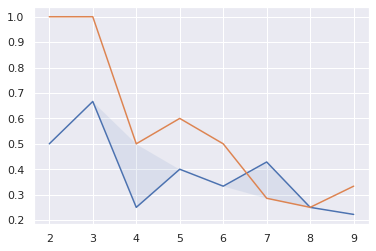

In [15]:
plt.plot(range(2,MAX_CLUSTER), spectral_middle_coverage);
plt.fill_between(range(2,MAX_CLUSTER), spectral_high_coverage, spectral_low_coverage, alpha=0.1);

plt.plot(range(2,MAX_CLUSTER), kmedoid_middle_coverage);
plt.fill_between(range(2,MAX_CLUSTER), kmedoid_high_coverage, kmedoid_low_coverage, alpha=0.1);